In [2]:
import os
import numpy as np
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import copy

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Tobia\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Tobia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
#PATH = '../finanz_vs_news'
PATH = r'..\HackathonDaten\Nachrichten und Kurse\\'
#PATH = ''

In [238]:
#############################################################
#### example how to read the daily stock rates with PATH ####
companyLabel = 'A'    # label of company to load / last column
df_stock = pd.read_csv(PATH+'StocksDaily\ALL_2007-01-01_2017-10-16.csv', parse_dates=["Date"])
StockTickers = df_stock['ticker'].unique()
df_stock = df_stock[df_stock['ticker']=='A']
# save data to pickle
df_stock.to_pickle(PATH+'StocksDaily\stock_'+companyLabel+'.pickle')

In [239]:
# read in data
df_stock = pd.read_pickle(PATH+'StocksDaily\stock_'+companyLabel+'.pickle')

In [233]:
#####################################
#### dictionary for stock labels ####
# get the ticker from our data
df_dummy = pd.read_csv(PATH+'StocksDaily\ALL_2007-01-01_2017-10-16.csv', parse_dates=["Date"])
StockTickers = df_dummy['ticker'].unique()   # get the unique tickers once
# read in dic with all tickers worldwide
TickerAll = pd.read_csv('Yahoo Ticker Symbols - September 2017.csv', delimiter=';')
# delete unneeded columns
del TickerAll['Country']
del TickerAll['Exchange']
# select onyl the ticker of the companies we have
TickerDic = TickerAll.loc[TickerAll['Ticker'].isin(StockTickers)]

namescat = copy.deepcopy(TickerDic['Name'].str.cat(sep = ' '))
namescat = namescat.replace(',' , ' ')
namescat = namescat.replace('.' , ' ')
namescat = namescat.split(' ')
namescat = pd.Series(namescat)
toDel = namescat.value_counts()[:24]
toDel = toDel.index.tolist()

del toDel[7]
del toDel[toDel == ' ']
# take longes ones first, otherwise in replace string one might only replace parts, leaving a rest
toDel.sort(key = lambda x: len(x), reverse=True)

shortName = copy.deepcopy(TickerDic['Name'].values)

stop_words = list(stopwords.words('english'))
for jj, dummy in enumerate(shortName):
    filtered = []
    word_tokens = word_tokenize(shortName[jj])
    for w in word_tokens:
        if w not in (stop_words + toDel + ['.', ',']):
            filtered.append(w)
    s = ' '
    #print(filtered)
    shortName[jj] = s.join(filtered)
TickerDic['RedName'] = shortName

# save dictionary
TickerDic.to_pickle('TickerDic.pickle')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [461]:
TickerAll[TickerAll['Ticker'] == 'C']
#TickerDic[TickerDic['Ticker']=='C']
TickerDic[TickerDic['Ticker']=='BLK']

,Ticker,Name,Category Name,RedName
966,BLK,"BlackRock, Inc.",Asset Management,BlackRock


In [221]:
#########################################
### LoughranMcDonald MasterDictionary ###
MasterDic = pd.read_csv('LoughranMcDonald_MasterDictionary_2016.csv', delimiter=';')

# get positive words
PosDic = MasterDic[MasterDic['Positive'] !=0]
PosDic = PosDic.sort_values(by=['Word Count'], ascending=False)
PosDic = PosDic['Word']
# save dictionary
PosDic.to_pickle('DicPositiveWords.pickle')

# get negative words
NegDic = MasterDic[MasterDic['Negative'] !=0]
NegDic = NegDic.sort_values(by=['Word Count'], ascending=False)
NegDic = NegDic['Word']
# save dictionary
NegDic.to_pickle('DicNegativeWords.pickle') 

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [222]:
# read in data
PosDic = pd.read_pickle('DicPositiveWords.pickle')
NegDic = pd.read_pickle('DicNegativeWords.pickle')

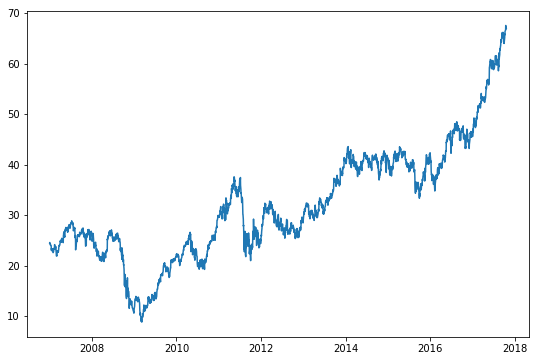

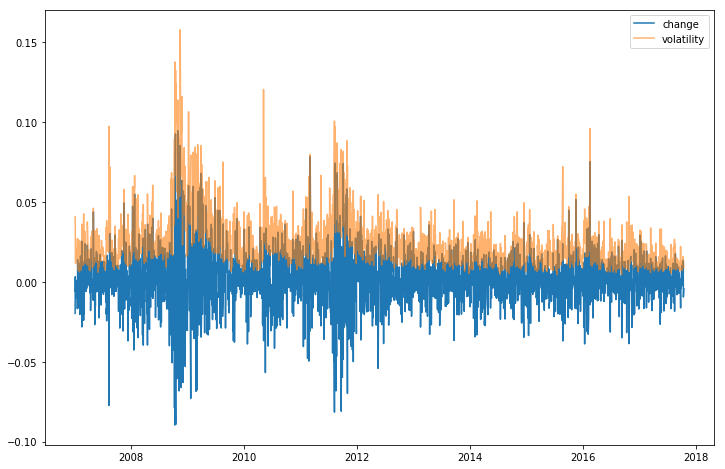

In [241]:
##################################################
datX = df_stock['Date']
datZ = df_stock['Close']
fig = plt.figure(figsize=(9,6))   # create a figure with specified size
ax1 = fig.add_subplot(111)        
ax1.set_xlabel('')                                  # set x label
ax1.set_ylabel('')                                  # set y label
ax1.plot(datX,datZ)                                 # plot

relChange = (df_stock['Close']-df_stock['Open']) / df_stock['Open']
relVolatility = (df_stock['High']-df_stock['Low'])/df_stock['Open'] 

fig = plt.figure(figsize=(12,8))   # create a figure with specified size
ax1 = fig.add_subplot(111)
ax1.plot(datX, relChange, alpha=1, label='change')
ax1.plot(datX, relVolatility, alpha=.6, label='volatility')
ax1.legend()

In [77]:
######################################
# make stock features and label

#companyLabel = 'BLK'
#companyLabel = 'GS'
companyLabel = 'MS'

def calcStockFeat(companyLabel):
    # read in stock data
    df_stock = pd.read_csv(PATH+'StocksDaily\ALL_2007-01-01_2017-10-16.csv', parse_dates=["Date"])
    #StockTickers = df_stock['ticker'].unique()
    df_stock = df_stock[df_stock['ticker']==companyLabel]
    
    # create the label
    diff_1d = df_stock['Close'].pct_change(periods=1)
    label = diff_1d > 0
    label = label.astype(np.int8)
    
    # get the derivative to the last day
    diff_1d = df_stock['Close'].pct_change(periods=1)
    diff_1d = diff_1d.shift(1)

    # get the derivative to the 7 day
    diff_7d = diff_1d.rolling(7).mean()
    
    res = df_stock[['Date','Close']]
    res['diff_1d'] = diff_1d
    res['diff_7d'] = diff_7d
    res['Label'] = label
   
    #save data to pickle
    res.to_pickle('stock_'+ companyLabel +'.pickle')
    return res

a = calcStockFeat(companyLabel)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexi

In [79]:
a

,Date,Close,diff_1d,diff_7d,Label
693286,2007-01-03,81.620003,NaN,NaN,0
693287,2007-01-04,81.910004,NaN,NaN,1
693288,2007-01-05,80.860001,0.003553,NaN,0
693289,2007-01-08,81.349998,-0.012819,NaN,1
693290,2007-01-09,81.160004,0.006060,NaN,0
693291,2007-01-10,81.570000,-0.002336,NaN,1
693292,2007-01-11,82.370003,0.005052,NaN,1
693293,2007-01-12,82.860001,0.009808,NaN,1
693294,2007-01-16,82.610001,0.005949,0.002181,0
693295,2007-01-17,82.379997,-0.003017,0.001242,0
